<a href="https://colab.research.google.com/github/ahzaidy/Programs/blob/main/CPSC_5440_HW31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch [1/2], Loss: 0.0201
Epoch [2/2], Loss: 0.0124


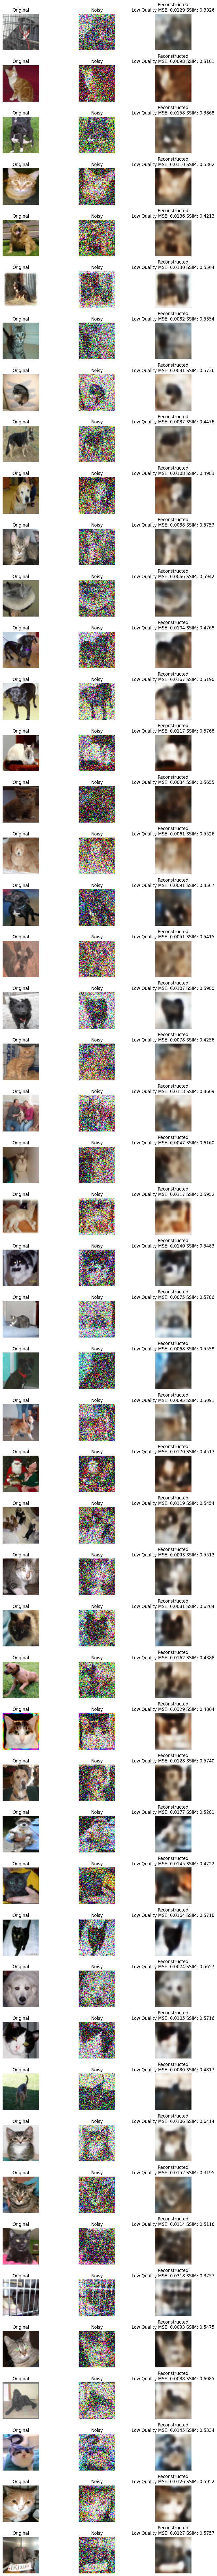

High Quality: 0 images
Moderate Quality: 0 images
Low Quality: 50 images


In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from google.colab import drive

# Connecting to Google Drive
drive.mount("/content/drive")

# Set dataset paths
train_dir = "/content/drive/My Drive/train/"
test_dir = "/content/drive/My Drive/test1/"

# Custom dataset class
class ImageDataset(Dataset):
    def __init__(self, directory, size=(56, 56)):
        self.directory = directory
        self.size = size
        self.filenames = [f for f in os.listdir(directory) if f.endswith(('.jpg', '.png', '.jpeg'))]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        file = self.filenames[idx]
        img_path = os.path.join(self.directory, file)
        img = Image.open(img_path).convert('RGB')  # Ensure RGB conversion
        img = img.resize(self.size)  # Proper resizing
        img = np.array(img) / 255.0  # Normalize
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)

        return img

# Create dataset and dataloader
batch_size = 64
train_dataset = ImageDataset(train_dir)
test_dataset = ImageDataset(test_dir)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Define Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize model, loss function, and optimizer
device = torch.device("cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        batch_noisy = batch + 0.5 * torch.randn_like(batch)
        batch_noisy = torch.clamp(batch_noisy, 0., 1.)

        optimizer.zero_grad()
        outputs = model(batch_noisy.to(device))
        loss = criterion(outputs, batch.to(device))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

# Save model
#torch.save(model.state_dict(), "/content/drive/My Drive/image_upscaler.pth")

# Evaluate model
model.eval()
mse_values = []
ssim_values = []
categories = {"High Quality": [], "Moderate Quality": [], "Low Quality": []}

mse_thresholds = [0.005, 0.02]
ssim_thresholds = [0.85, 0.65]

fig, axes = plt.subplots(50, 3, figsize=(10, 100))  # 50 rows, 3 columns
image_count = 0

for batch in test_loader:
    if image_count >= 50:
        break

    batch_noisy = batch + 0.5 * torch.randn_like(batch)
    batch_noisy = torch.clamp(batch_noisy, 0., 1.)

    with torch.no_grad():
        reconstructed = model(batch_noisy.to(device)).cpu().numpy()

    for j in range(batch.shape[0]):
        if image_count >= 50:
            break

        original = batch[j].permute(1, 2, 0).numpy()
        noisy = batch_noisy[j].permute(1, 2, 0).numpy()
        recon = reconstructed[j].transpose(1, 2, 0)

        mse = mean_squared_error(original.flatten(), recon.flatten())
        mse_values.append(mse)
        ssim_index = ssim(original, recon, data_range=1.0, channel_axis=-1)
        ssim_values.append(ssim_index)

        if mse < mse_thresholds[0] and ssim_index > ssim_thresholds[0]:
            category = "High Quality"
        elif mse < mse_thresholds[1] and ssim_index > ssim_thresholds[1]:
            category = "Moderate Quality"
        else:
            category = "Low Quality"
        categories[category].append(image_count)

        axes[image_count, 0].imshow(original)
        axes[image_count, 0].set_title(f"Original")
        axes[image_count, 0].axis("off")

        axes[image_count, 1].imshow(noisy)
        axes[image_count, 1].set_title("Noisy")
        axes[image_count, 1].axis("off")

        axes[image_count, 2].imshow(recon)
        axes[image_count, 2].set_title(f"Reconstructed\n{category} MSE: {mse:.4f} SSIM: {ssim_index:.4f}")
        axes[image_count, 2].axis("off")

        image_count += 1

plt.tight_layout()
plt.show()

# Print categorization summary
for category, indices in categories.items():
    print(f"{category}: {len(indices)} images")

In [5]:
!pip install PIL

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL
